# Genz Discontinuous Integrand Family

In [1]:
# set python to pick up local directory
from pathlib import Path
import sys
import os
path_root = Path(os.getcwd()).parents[0]
sys.path.append(str(path_root))
%reload_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter('always', category=FutureWarning)

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from copy import deepcopy
import itertools
from sklearn.model_selection import train_test_split
import mlflow

In [3]:
import jax
import jax.numpy as jnp
from jax import vmap, jit
from tensorflow_probability.substrates.jax import distributions as tfd
import optax
import equinox as eqx
from jax.lib import xla_bridge

In [4]:
from solstice.kernels import RBF, RFF, Matern32
from solstice.gp import GP, LowRankGP, fitgp
from solstice.transforms import ARD, FiniteARD
from ffbq.bq import BQ
from ffbq.helpers import grid, regrid
from ffbq.eval import metric_gp_bq, generate_data

In [5]:
from ffbq.genz import GenzDiscontinuous

In [6]:
jax.clear_caches()
print(f"device: {xla_bridge.get_backend().platform}")

device: gpu


# Define Experiment

In [7]:
key = jax.random.PRNGKey(2023)
EXPERIMENT = "discontinuous_dev"

In [8]:
# genz = GenzDiscontinuous(d=2)
# X, y, yn = genz.sample(1000, key=key)
# fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# ax.scatter(X[:, 0], X[:, 1], y, cmap=cm.viridis, linewidth=0, antialiased=True, label="fft", s=5)

In [9]:
def gaussian_bq(gp, m, X, y, bounds, key, diag=None):
    bq = BQ(gp, m)
    mu, sigma = bq(X, y, bounds=bounds, key=key, diag=diag)
    return mu, sigma

def mc_bq(gp, m, X_train, y_train, R, bounds, key, diag=None):
    bq = BQ(gp, m, operator="mc")
    mu, sigma = bq(X_train, y_train, bounds=bounds, R=R, key=key,
                   diag=diag)
    return mu, sigma

def qmc_bq(gp, m, X_train, y_train, R, bounds, key, diag=None):
    bq = BQ(gp, m, operator="qmc")
    mu, sigma = bq(X_train, y_train, bounds=bounds, R=R, key=key,
                   diag=diag)
    return mu, sigma

def fft_bq(gp, m, X_train, y_train, sr, bounds, diag=None):
    bq = BQ(gp, m, operator="fft")
    mu, sigma = bq(X_train, y_train, bounds=bounds, sr=sr, diag=diag)
    return mu, sigma

def lr_qmc_bq(gp, m, X_train, y_train, R, bounds, diag=None):
    bq = BQ(gp, m, operator="lr")
    mu, sigma = bq(X_train, y_train, bounds=bounds, R=R, diag=diag)
    return mu, sigma

def lr_fft_bq(gp, m, X_train, y_train, sampling_rate, bounds, diag=None):
    bq = BQ(gp, m, operator="lrfft")
    mu, sigma = bq(X_train, y_train, bounds=bounds, sr=sampling_rate, diag=diag)
    return mu, sigma

## Define Run

In [10]:
diag = 1e-4
lr = 0.01
epochs = 200

In [11]:
sols_d = {
    2: (5.001926847246786, 0.0), 3: (11.18680335224355, 0.0), 
    4: (25.019272185208177, 0.0), 5: (55.95557202245736, 0.0), 
    6: (125.14456924176754, 0.0), 7: (279.88567795218063, 0.0), 
    8: (625.9639806775316, 0.0)
}

In [12]:
SRs = [4, 8, 16, 32, 64, 128]
Ns = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
ds = [2, 3, 4, 5, 6, 7, 8]
# seeds = jax.random.split(jax.random.PRNGKey(2023), 10)
run_params = itertools.product(SRs, Ns, ds)

In [13]:
def single_run(d, R, N, sampling_rate, key, EXPERIMENT=None, log=True):
    print(f'd: {d}, R: {R}, N: {N}, sr: {sampling_rate}')

    diag_rbf = 1e-1
    diag_m32 = 1e-1
    diag_fin = 1e-1
    diag_lr = 1e-1
    diag_lr_fft = 1e-1

    if EXPERIMENT is None:
        EXPERIMENT = "discontinuous_dev"

    sol = sols_d[d]
    genz = GenzDiscontinuous(d)
    ls_init = (genz.bounds[1,:] - genz.bounds[0,:]) / 2

    # make data
    train, val, test = generate_data(genz, N * 3, N, N, noise=None, key=key)
    X_train, y_train = train
    X_val, y_val = val
    X_test, y_test = test
    Nconv = grid(genz.bounds, sampling_rate=sampling_rate).shape[0]
    Nconv_cap = 100000
    Nrff_cap = 500000

    # --------------------------------------- TRAIN GPS -------------------------------------- #

    ###### BASIC BQ GP
    def build_train_bq_gp(X, y, opt, epochs, ls_init, diag):
        gp_pre = GP(ARD(ls_init, RBF()), X, diag=diag)

        # train
        gp, loss = fitgp(gp_pre, y, opt, epochs, to_train=lambda t: t.kernel.scale, verbose=False, solver="full")
        return gp_pre, gp, loss

    gp_bq_opt = optax.adam(lr)
    print("training basic gp...")
    _, gp_bq, _ = build_train_bq_gp(X_train, y_train, gp_bq_opt, epochs, ls_init, diag)

    ###### RBF GP
    def build_train_rbf_gp(support, X, y, opt, epochs, ls_init, diag):
        gp_pre = GP(FiniteARD(ls_init, RBF(), support), X, diag=diag)

        # train
        gp, loss = fitgp(gp_pre, y, opt, epochs, to_train=lambda t: t.kernel.scale, verbose=False, solver="full")
        return gp_pre, gp, loss

    gp_rbf_opt = optax.adam(lr)
    print("training rbf gp...")
    _, gp_rbf, _ = build_train_rbf_gp(genz.bounds, X_train, y_train, gp_rbf_opt, epochs, ls_init, diag)

    ###### MATERN 3/2 GP
    def build_train_mat32_gp(d, R, support, X, y, opt, epochs, ls_init, diag, key):
        gp_pre = GP(FiniteARD(ls_init, RFF(key, d, R, base_kernel=Matern32()), support), X, diag=diag)

        # train
        gp, loss = fitgp(gp_pre, y, opt, epochs, to_train=lambda t: (t.kernel.scale), 
                        verbose=False, solver="full")
        return gp_pre, gp, loss

    gp_mat32_opt = optax.adam(lr * 10)
    _, gp_mat32, _ = build_train_mat32_gp(d, R, genz.bounds, X_train, y_train, gp_mat32_opt, epochs, ls_init, diag, key=key)

    # ###### RFF GP
    # def build_train_rff(d, R, X, y, opt, epochs, ls_init, diag, key):
    #     gp_pre = GP(ARD(ls_init, RFF(key, d, R)), X, diag=diag)

    #     # train
    #     gp, loss = fitgp(gp_pre, y, opt, epochs, to_train=lambda t: (t.kernel.scale, t.kernel.kernel.w), 
    #                     verbose=False, solver="full")
    #     return gp_pre, gp, loss

    # gp_rff_opt = optax.adam(lr * 10)
    # _, gp_rff, _ = build_train_rff(d, R, X_train, y_train, gp_rff_opt, epochs, ls_init, diag, key=key)


    ###### FINITE RFF GP
    def build_train_fin(d, R, support, X, y, opt, epochs, ls_init, diag, key):

        gp_pre = GP(FiniteARD(ls_init, RFF(key, d, R), support), X, diag=diag)

        gp, loss = fitgp(
            gp_pre, y, opt, epochs, to_train=lambda t: (t.kernel.scale, t.kernel.kernel.w), 
            verbose=False, solver="full"
        )
        
        return gp_pre, gp, loss

    gp_fin_opt = optax.adam(lr)
    print("training finite gp...")
    _, gp_fin, _ = build_train_fin(d, R, genz.bounds, X_train, y_train, gp_fin_opt, epochs, ls_init, diag, key=key)
    
    ###### LOW RANK RBF GP
    def build_train_lrgp_rbf(d, R, X, y, opt, epochs, ls_init, diag, key):
        gp_pre = LowRankGP(ARD(ls_init, RFF(key, d, R)), X, diag=diag)

        # train
        gp, loss = fitgp(gp_pre, y, opt, epochs, to_train=lambda t: (t.kernel.scale), 
                        verbose=False, solver="full")
        return gp_pre, gp, loss

    gp_lr_rbf_opt = optax.adam(lr)
    print("training low rank rbf gp...")
    _, gp_lr_rbf, _ = build_train_lrgp_rbf(d, R, X_train, y_train, gp_lr_rbf_opt, epochs, ls_init, diag_lr, key=key)

    ###### LOW RANK MATERN32 GP
    def build_train_lrgp_mat32(d, R, X, y, opt, epochs, ls_init, diag, key):
        gp_pre = LowRankGP(ARD(ls_init, RFF(key, d, R, base_kernel=Matern32())), X, diag=diag)

        # train
        gp, loss = fitgp(gp_pre, y, opt, epochs, to_train=lambda t: (t.kernel.scale), 
                        verbose=False, solver="full")
        return gp_pre, gp, loss

    gp_lr_mat32_opt = optax.adam(lr)
    print("training low rank matern 3/2 gp...")
    _, gp_lr_mat32, _ = build_train_lrgp_mat32(d, R, X_train, y_train, gp_lr_mat32_opt, epochs, ls_init, diag_lr, key=key)

    ###### LOW RANK RFF GP
    def build_train_lrgp_rff(d, R, X, y, opt, epochs, ls_init, diag, key):
        gp_pre = LowRankGP(ARD(ls_init, RFF(key, d, R)), X, diag=diag)

        # train
        gp, loss = fitgp(gp_pre, y, opt, epochs, to_train=lambda t: (t.kernel.scale, t.kernel.kernel.w), 
                        verbose=False)
        return gp_pre, gp, loss

    gp_lr_rff_opt = optax.adam(lr)
    print("training low rank RFF gp...")
    _, gp_lr_rff, _ = build_train_lrgp_rff(d, R, X_train, y_train, gp_lr_rff_opt, epochs, ls_init, diag_lr, key=key)

    # make test GPs for BQ
    gp_bq = eqx.tree_at(lambda t: t.X, gp_bq, replace_fn=lambda _: X_val)
    gp_rbf = eqx.tree_at(lambda t: t.X, gp_rbf, replace_fn=lambda _: X_val)
    gp_mat32 = eqx.tree_at(lambda t: t.X, gp_mat32, replace_fn=lambda _: X_val)
    # gp_rff = eqx.tree_at(lambda t: t.X, gp_rff, replace_fn=lambda _: X_val)
    gp_fin = eqx.tree_at(lambda t: t.X, gp_fin, replace_fn=lambda _: X_val)
    gp_lr_rbf = eqx.tree_at(lambda t: t.X, gp_lr_rbf, replace_fn=lambda _: X_val)
    gp_lr_mat32 = eqx.tree_at(lambda t: t.X, gp_lr_mat32, replace_fn=lambda _: X_val)
    gp_lr_rff = eqx.tree_at(lambda t: t.X, gp_lr_rff, replace_fn=lambda _: X_val)

    # ---------------------------------------- RUN BQ ---------------------------------------- #
    m = tfd.MultivariateNormalDiag(jnp.ones(d) * 0.5, jnp.ones(d) * 10)
    print("running BQ models...")

    ########## GAUSSIAN BQ
    rbf_res, _ = gaussian_bq(gp_bq, m, X_val, y_val, genz.bounds, key, diag=diag_rbf)

    ########## MC
    if Nconv > Nconv_cap:
        Nconv_mc = Nconv_cap
        print(f"Capping N mc from {Nconv} to {Nconv_cap}")
    else:
        Nconv_mc = Nconv

    rbf_mc_res, _ = mc_bq(gp_rbf, m, X_val, y_val, Nconv_mc, genz.bounds, key, diag=diag_rbf)
    mat32_mc_res, _ = mc_bq(gp_mat32, m, X_val, y_val, Nconv_mc, genz.bounds, key, diag=diag_m32)
    # rff_mc_res, _ = mc_bq(gp_rff, m, X_val, y_val, Nconv_mc, genz.bounds, key)
    fin_mc_res, _ = mc_bq(gp_fin, m, X_val, y_val, Nconv_mc, genz.bounds, key, diag=diag_fin)

    ########## QMC
    rbf_qmc_res, _ = qmc_bq(gp_rbf, m, X_val, y_val, Nconv_mc, genz.bounds, key, diag=diag_rbf)
    mat32_qmc_res, _ = qmc_bq(gp_mat32, m, X_val, y_val, Nconv_mc, genz.bounds, key, diag=diag_m32)
    # rff_qmc_res, rff_qmc_z = qmc_bq(gp_rff, m, X_train, y_train, Nconv_mc, genz.bounds, key)
    fin_qmc_res, _ = qmc_bq(gp_fin, m, X_val, y_val, Nconv_mc, genz.bounds, key, diag=diag_fin)

    ########## FFBQ
    rbf_fft_res, _ = fft_bq(gp_rbf, m, X_val, y_val, sampling_rate, genz.bounds, diag=diag_rbf)
    mat32_fft_res, _ = fft_bq(gp_mat32, m, X_val, y_val, sampling_rate, genz.bounds, diag=diag_m32)
    # rff_fft_res, rff_fft_z = fft_bq(gp_rff, m2, X_train, y_train, sampling_rate, genz.bounds)
    fin_fft_res, _ = fft_bq(gp_fin, m, X_val, y_val, sampling_rate, genz.bounds, diag=diag_fin)

    ########## SSBQ (QMC)
    if Nconv > Nrff_cap:
        Nrff = Nrff_cap
        print(f"Capping N RFF from {Nconv} to {Nrff_cap}")
    else:
        Nrff = Nconv
    lr_rbf_res, _ = lr_qmc_bq(gp_lr_rbf, m, X_val, y_val, Nrff, genz.bounds, diag=diag_lr)
    lr_mat32_res, _ = lr_qmc_bq(gp_lr_mat32, m, X_val, y_val, Nrff, genz.bounds, diag=diag_lr)
    lr_rff_res, _ = lr_qmc_bq(gp_lr_rff, m, X_val, y_val, Nrff, genz.bounds, diag=diag_lr)

    ########## SSBQ (FFT)
    if d < 3:
        lrfft_rbf_res, _ = lr_fft_bq(gp_lr_rbf, m, X_val, y_val, sampling_rate, genz.bounds, diag=diag_lr_fft)
        lrfft_mat32_res, _ = lr_fft_bq(gp_lr_mat32, m, X_val, y_val, sampling_rate, genz.bounds, diag=diag_lr_fft)
        lrfft_rff_res, _ = lr_fft_bq(gp_lr_rff, m, X_val, y_val, sampling_rate, genz.bounds, diag=diag_lr_fft)

    # ----------------------------------- ERROR AND OUTPUT ----------------------------------- #
    rbf_err = jnp.abs(rbf_res - sol[0]) / sol[0]
    qmc_rel_errs = jnp.abs(jnp.array([rbf_qmc_res, mat32_qmc_res, fin_qmc_res]) - sol[0]) / sol[0]
    mc_rel_errs = jnp.abs(jnp.array([rbf_mc_res, mat32_mc_res, fin_mc_res]) - sol[0]) / sol[0]
    ffbq_rel_errs = jnp.abs(jnp.array([rbf_fft_res, mat32_fft_res, fin_fft_res]) - sol[0]) / sol[0]
    ssbq_rel_errs = jnp.abs(jnp.array([lr_rbf_res, lr_mat32_res, lr_rff_res]) - sol[0]) / sol[0]
    if d < 3:
        ssbq_fft_rel_errs = jnp.abs(jnp.array([lrfft_rbf_res, lrfft_mat32_res, lrfft_rff_res]) - sol[0]) / sol[0]
    else:
        ssbq_fft_rel_errs = None

    print(f"""
        Gaussian: {rbf_err} \n 
        MC: {mc_rel_errs} \n
        QMC: {qmc_rel_errs} \n 
        FFBQ: {ffbq_rel_errs} \n 
        SSBQ (QMC): {ssbq_rel_errs} \n
        SSBQ (FFT): {ssbq_fft_rel_errs} \n
    """)

    artifacts = {
        "genz": genz,
        "m": m,
        "val": (X_val, y_val),
        "test": (X_test, y_test),
        "gps": {
            "rbf": gp_rbf,
            "mat32": gp_mat32,
            # "rff": gp_rff,
            "fin": gp_fin,
            "lr_rbf": gp_lr_rbf,
            "lr_mat32": gp_lr_mat32,
            "lr_rff": gp_lr_rff
        }
    }
    
    if not log:
        return artifacts

    # -------------------------------------- SAVE MODELS ------------------------------------- #
    ########## GAUSSIAN BQ
    metric_gp_bq(
        gp=gp_bq, bq_res=rbf_res,
        y_val=y_val, X_test=X_test, y_test=y_test, sol=sol, 
        experiment=EXPERIMENT, gptype="gp", ktype="rbf", bqtype="gaussian", 
        epochs=epochs, lr=lr, key=key, diag=diag_rbf
    )

    ########## MC
    metric_gp_bq(
        gp=gp_rbf, bq_res=rbf_mc_res,
        y_val=y_val, X_test=X_test, y_test=y_test, sol=sol, 
        experiment=EXPERIMENT, gptype="gp", ktype="rbf", bqtype="mc", 
        epochs=epochs, lr=lr, key=key, Nconv=Nconv_mc, diag=diag_rbf
    )
    metric_gp_bq(
        gp=gp_mat32, bq_res=mat32_mc_res,
        y_val=y_val, X_test=X_test, y_test=y_test, sol=sol, 
        experiment=EXPERIMENT, gptype="gp", ktype="mat32", bqtype="mc", 
        epochs=epochs, lr=lr, key=key, Nconv=Nconv_mc, R=R
    )
    metric_gp_bq(
        gp=gp_fin, bq_res=fin_mc_res,
        y_val=y_val, X_test=X_test, y_test=y_test, sol=sol, 
        experiment=EXPERIMENT, gptype="gp", ktype="fin", bqtype="mc", 
        epochs=epochs, lr=lr, key=key, Nconv=Nconv_mc, R=R, diag=1e-1
    )

    ########## QMC
    metric_gp_bq(
        gp=gp_rbf, bq_res=rbf_qmc_res,
        y_val=y_val, X_test=X_test, y_test=y_test, sol=sol, 
        experiment=EXPERIMENT, gptype="gp", ktype="rbf", bqtype="qmc", 
        epochs=epochs, lr=lr, key=key, Nconv=Nconv_mc, diag=diag_rbf
    )
    metric_gp_bq(
        gp=gp_mat32, bq_res=mat32_qmc_res,
        y_val=y_val, X_test=X_test, y_test=y_test, sol=sol, 
        experiment=EXPERIMENT, gptype="gp", ktype="mat32", bqtype="qmc", 
        epochs=epochs, lr=lr, key=key, Nconv=Nconv_mc, R=R
    )
    metric_gp_bq(
        gp=gp_fin, bq_res=fin_qmc_res,
        y_val=y_val, X_test=X_test, y_test=y_test, sol=sol, 
        experiment=EXPERIMENT, gptype="gp", ktype="fin", bqtype="qmc", 
        epochs=epochs, lr=lr, key=key, Nconv=Nconv_mc, R=R, diag=1e-1
    )

    ########## FFBQ
    metric_gp_bq(
        gp=gp_rbf, bq_res=rbf_fft_res,
        y_val=y_val, X_test=X_test, y_test=y_test, sol=sol, 
        experiment=EXPERIMENT, gptype="gp", ktype="rbf", bqtype="ffbq", 
        epochs=epochs, lr=lr, key=key, Nconv=Nconv, diag=3e-1
    )
    metric_gp_bq(
        gp=gp_mat32, bq_res=mat32_fft_res,
        y_val=y_val, X_test=X_test, y_test=y_test, sol=sol,
        experiment=EXPERIMENT, gptype="gp", ktype="mat32", bqtype="ffbq", 
        epochs=epochs, lr=lr, key=key, Nconv=Nconv, diag=3e-1, R=R
    )
    metric_gp_bq(
        gp=gp_fin, bq_res=fin_fft_res,
        y_val=y_val, X_test=X_test, y_test=y_test, sol=sol, 
        experiment=EXPERIMENT, gptype="gp", ktype="fin", bqtype="ffbq", 
        epochs=epochs, lr=lr, key=key, Nconv=Nconv, diag=1e-1, R=R
    )

    ########## SSBQ
    metric_gp_bq(
        gp=gp_lr_rbf, bq_res=lr_rbf_res,
        y_val=y_val, X_test=X_test, y_test=y_test, sol=sol, 
        experiment=EXPERIMENT, gptype="lr", ktype="rbf", bqtype="ssbq", 
        epochs=epochs, lr=lr, key=key, Nconv=Nrff, R=R
    )
    metric_gp_bq(
        gp=gp_lr_mat32, bq_res=lr_mat32_res,
        y_val=y_val, X_test=X_test, y_test=y_test, sol=sol, 
        experiment=EXPERIMENT, gptype="lr", ktype="mat32", bqtype="ssbq", 
        epochs=epochs, lr=lr, key=key, Nconv=Nrff, R=R
    )
    metric_gp_bq(
        gp=gp_lr_rff, bq_res=lr_rff_res,
        y_val=y_val, X_test=X_test, y_test=y_test, sol=sol, 
        experiment=EXPERIMENT, gptype="lr", ktype="rff", bqtype="ssbq", 
        epochs=epochs, lr=lr, key=key, Nconv=Nrff, R=R
    )

    ########## SSBQ (FFT)
    if d < 3:
        metric_gp_bq(
            gp=gp_lr_rbf, bq_res=lrfft_rbf_res,
            y_val=y_val, X_test=X_test, y_test=y_test, sol=sol, 
            experiment=EXPERIMENT, gptype="lr", ktype="rbf", bqtype="lrfft", 
            epochs=epochs, lr=lr, key=key, Nconv=Nconv, R=R
        )
        metric_gp_bq(
            gp=gp_lr_mat32, bq_res=lrfft_mat32_res,
            y_val=y_val, X_test=X_test, y_test=y_test, sol=sol, 
            experiment=EXPERIMENT, gptype="lr", ktype="mat32", bqtype="lrfft", 
            epochs=epochs, lr=lr, key=key, Nconv=Nconv, R=R
        )
        metric_gp_bq(
            gp=gp_lr_rff, bq_res=lrfft_rff_res,
            y_val=y_val, X_test=X_test, y_test=y_test, sol=sol, 
            experiment=EXPERIMENT, gptype="lr", ktype="rff", bqtype="lrfft", 
            epochs=epochs, lr=lr, key=key, Nconv=Nconv, R=R
        )

    del artifacts


In [14]:
def multi_seed_run(d, R, N, sampling_rate, global_key, n_runs=10, EXPERIMENT=None, log=True):
    run_keys = jax.random.split(global_key, n_runs)

    artifacts = []
    for rk in run_keys:
        print(f"starting experiment with seed {rk.tolist()[1]}")
        if log:
            single_run(d, R, N, sampling_rate, rk, EXPERIMENT=EXPERIMENT, log=log)
        else:
            run_artifacts = single_run(d, R, N, sampling_rate, rk, EXPERIMENT=EXPERIMENT, log=log)
            artifacts.append(run_artifacts)
    return artifacts

## Single Run

In [15]:
# res = single_run(3, 100, 1000, 32, key, log=False)
# runs = multi_seed_run(d=3, R=100, N=1000, sampling_rate=12, global_key=key, n_runs=5, log=False)

# gp_rbf = res["gps"]["rbf"]
# lr_rff = res["gps"]["lr_rff"]
# lr_rbf = res["gps"]["lr_rbf"]
# X, y = res["val"]
# m = res["m"]
# genz = res["genz"]
# Nconv = grid(genz.bounds, 16).shape[0]
# grid_dims = grid(genz.bounds, 16, flatten=False).shape[:-1]

# rbf_res, rbf_z = gaussian_bq(gp_rbf, m, X, y, genz.bounds, key, diag=1e-1)
# fft_rbf_res, fft_rbf_z = fft_bq(gp_rbf, m, X, y, 16, genz.bounds, diag=1e-1)
# qmc_rbf_res, qmc_rbf_z = qmc_bq(gp_rbf, m, X, y, Nconv, genz.bounds, diag=1e-1, key=key)
# lrqmc_res, _ = lr_qmc_bq(lr_rbf, m, X, y, 100000, genz.bounds, diag=1e-1)
# lrfft_res, _ = lr_fft_bq(lr_rbf, m, X, y, sampling_rate=16, bounds=genz.bounds, diag=1e-1)
# rbf_res, qmc_rbf_res, fft_rbf_res, lrqmc_res, lrfft_res

# fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# ax.view_init(elev=0., azim=0)
# ax.scatter(X[:, 0], X[:, 1], rbf_z, cmap=cm.viridis, linewidth=0, antialiased=True, label="bq", s=5)
# ax.scatter(X[:, 0], X[:, 1], qmc_rbf_z, cmap=cm.viridis, linewidth=0, antialiased=True, label="qmc", s=5)
# ax.scatter(X[:, 0], X[:, 1], fft_rbf_z, cmap=cm.viridis, linewidth=0, antialiased=True, label="fft", s=5)

# ax.legend()

## Run Over D

In [16]:
def sample_rate_to_n(sr, ds):
    dim_lens = [
        jnp.arange(0, 1+1/sr[i], 1/sr[i]).shape[0]**ds[i]
        for i in range(len(sr))
    ]
    return dim_lens

srs_d = [100, 64, 30, 20, 12, 4.5, 2][0:-2]
ds = list(sols_d.keys())[0:-2]
ds, srs_d, sample_rate_to_n(srs_d, ds)

([2, 3, 4, 5, 6],
 [100, 64, 30, 20, 12],
 [10201, 274625, 1048576, 4084101, 4826809])

In [17]:
exp_name_d = "discontinuous_dev_d"

# client = mlflow.MlflowClient()
# client.delete_experiment(client.get_experiment_by_name(exp_name_d).experiment_id)

In [ ]:
artifacts = []
for i, d in enumerate(ds):
    print(f"# ------------------------------------------- {d} ------------------------------------------ #")
    d_arts = multi_seed_run(
        d=d, R=100, N=1000, sampling_rate=srs_d[i], global_key=key, 
        n_runs=10, EXPERIMENT=exp_name_d, log=True)
    artifacts.append(d_arts)

# Evaluate

In [7]:
from ffbq.eval import get_experiments, best_operator_models, seed_summary, best_operator_plurality
import mlflow
import numpy as np

In [8]:
# client = mlflow.MlflowClient()

# exps, exp_cols = get_experiments(exp_name_d)
# # Delete old experiments
# for run in exps[exps["d"] == "3"].run_id:
#     client.delete_run(run)

### Results over D

In [9]:
exp_name_d = "discontinuous_dev_d"
exps, exp_cols = get_experiments(exp_name_d)
d_sum = seed_summary(exps, exp_cols, "d")

In [10]:
best_each_d = best_operator_models(d_sum, metric="nll_mean", setting="d")
# best_each_d = best_operator_models(d_sum, setting="d")
best_each_d = best_each_d[~best_each_d["operator"].isin(["lrfft", "mc"])]
best_each_d

,gptype,ktype,operator,sol,d,bqerr_mean,bqerr_std,bqrel_mean,bqrel_std,nll_mean,nll_std
2,lr,rff,ssbq,5.001926847246786,2,0.106328,0.104919,0.021257,0.020976,1.355825e+05,4.080600e+04
5,gp,rbf,gaussian,5.001926847246786,2,0.112345,0.079370,0.022460,0.015868,8.149962e+07,3.469377e+07
11,gp,rbf,ffbq,5.001926847246786,2,0.178276,0.096808,0.035641,0.019354,2.109979e+06,3.538364e+06
13,gp,rbf,qmc,5.001926847246786,2,0.190411,0.105937,0.038068,0.021179,2.109979e+06,3.538364e+06
16,gp,rbf,gaussian,11.18680335224355,3,0.724960,0.727552,0.064805,0.065037,1.378675e+08,1.367858e+08
20,lr,rff,ssbq,11.18680335224355,3,0.973604,0.918503,0.087031,0.082106,4.882691e+06,1.424434e+06
21,gp,mat32,qmc,11.18680335224355,3,0.991867,0.598448,0.088664,0.053496,1.817854e+06,5.309882e+05
28,gp,mat32,ffbq,11.18680335224355,3,1.343137,1.363423,0.120064,0.121878,1.817854e+06,5.309882e+05
36,gp,rbf,gaussian,25.019272185208177,4,4.173277,3.705115,0.166802,0.148090,1.205656e+09,1.954301e+09
40,lr,rff,ssbq,25.019272185208177,4,6.407219,3.296965,0.256091,0.131777,1.125737e+08,7.667127e+07


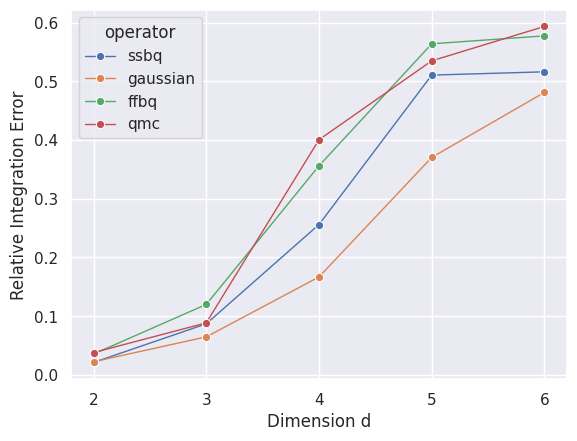

In [11]:
sns.set_theme()
fig = sns.lineplot(
    best_each_d, x="d", y="bqrel_mean", hue="operator", 
    linewidth=1, estimator="lowess", marker="o"
)
# fig.set(yscale="log")

# for operator, color in zip(best_each_d['operator'].unique(), sns.color_palette()):
#     subset = best_each_d[best_each_d['operator'] == operator]
#     plt.errorbar(x=subset['d'], y=subset['bqrel_mean'], yerr=subset['bqrel_std'], fmt='o', color=color, capsize=5)

plt.xlabel("Dimension d")
plt.ylabel("Relative Integration Error")

plt.show()

In [12]:
# best across d as a plurality
best_over_d = best_operator_plurality(d_sum, best_each_d)
best_over_d

,gptype,ktype,operator,sol,d,bqerr_mean,bqerr_std,bqrel_mean,bqrel_std,nll_mean,nll_std
0,gp,mat32,qmc,5.001926847246786,2,0.101674,0.096709,0.020327,0.019334,1.235728e+07,1.288086e+07
1,lr,rff,ssbq,5.001926847246786,2,0.106328,0.104919,0.021257,0.020976,1.355825e+05,4.080600e+04
2,gp,mat32,ffbq,5.001926847246786,2,0.107034,0.106662,0.021399,0.021324,1.235728e+07,1.288086e+07
3,gp,rbf,gaussian,5.001926847246786,2,0.112345,0.079370,0.022460,0.015868,8.149962e+07,3.469377e+07
4,gp,rbf,gaussian,11.18680335224355,3,0.724960,0.727552,0.064805,0.065037,1.378675e+08,1.367858e+08
5,lr,rff,ssbq,11.18680335224355,3,0.973604,0.918503,0.087031,0.082106,4.882691e+06,1.424434e+06
6,gp,mat32,qmc,11.18680335224355,3,0.991867,0.598448,0.088664,0.053496,1.817854e+06,5.309882e+05
7,gp,mat32,ffbq,11.18680335224355,3,1.343137,1.363423,0.120064,0.121878,1.817854e+06,5.309882e+05
8,gp,rbf,gaussian,25.019272185208177,4,4.173277,3.705115,0.166802,0.148090,1.205656e+09,1.954301e+09
9,lr,rff,ssbq,25.019272185208177,4,6.407219,3.296965,0.256091,0.131777,1.125737e+08,7.667127e+07


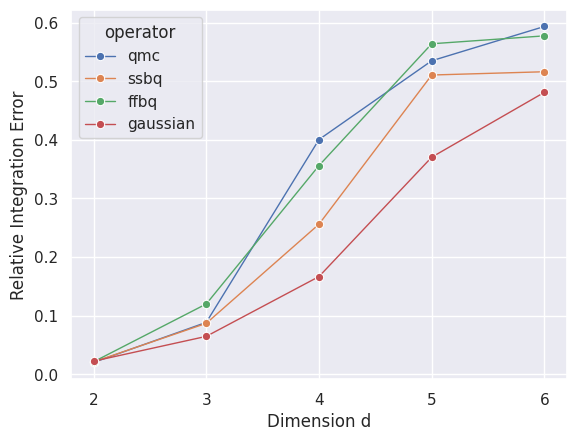

In [13]:
sns.set_theme()
fig = sns.lineplot(
    best_over_d, x="d", y="bqrel_mean", hue="operator", 
    linewidth=1, estimator="lowess", marker="o"
)
# fig.set(yscale="log")

# for operator, color in zip(best_each_d['operator'].unique(), sns.color_palette()):
#     subset = best_each_d[best_each_d['operator'] == operator]
#     plt.errorbar(x=subset['d'], y=subset['bqrel_mean'], yerr=subset['bqrel_std'], fmt='o', color=color, capsize=5)

plt.xlabel("Dimension d")
plt.ylabel("Relative Integration Error")

plt.show()

In [14]:
# fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# ax.view_init(elev=0., azim=0)
# ax.scatter(X_train[:, 0], X_train[:, 1], rff_qmc_z, cmap=cm.viridis, linewidth=0, antialiased=True, label="mc", s=5)
# ax.scatter(X_train[:, 0], X_train[:, 1], rff_fft_z, cmap=cm.viridis, linewidth=0, antialiased=True, label="fft", s=5)

# ax.legend()

## Tables

In [15]:
paper_tab = best_over_d[["operator", "ktype", "d", "bqerr_mean", "bqerr_std"]]
paper_tab = paper_tab[paper_tab["d"].isin(['2', '4', '6'])]
paper_tab["model"] = paper_tab["operator"] + " " + paper_tab["ktype"]
paper_tab = paper_tab.drop(columns=["operator", "ktype"])
paper_tab_mean = paper_tab.pivot(index="model", columns="d", values="bqerr_mean").reset_index()
paper_tab_std = paper_tab.pivot(index="model", columns="d", values="bqerr_std").reset_index()
joint_df = paper_tab_mean.copy()

In [16]:
joint_df

d,model,2,4,6
0,ffbq mat32,0.107034,8.909072,72.238398
1,gaussian rbf,0.112345,4.173277,60.193223
2,qmc mat32,0.101674,10.019012,74.246253
3,ssbq rff,0.106328,6.407219,64.580820


In [17]:
for col in ["2", "4", "6"]:
    joint_df[col] = joint_df[col].map("{:.2e}".format) + " ± " + paper_tab_std[col].map("{:.2e}".format)

In [18]:
print(joint_df.iloc[[1, 2, 0, 3]].to_latex(index=False, escape=False))

\begin{tabular}{llll}
\toprule
model & 2 & 4 & 6 \\
\midrule
gaussian rbf & 1.12e-01 ± 7.94e-02 & 4.17e+00 ± 3.71e+00 & 6.02e+01 ± 3.27e+01 \\
qmc mat32 & 1.02e-01 ± 9.67e-02 & 1.00e+01 ± 5.97e+00 & 7.42e+01 ± 3.06e+01 \\
ffbq mat32 & 1.07e-01 ± 1.07e-01 & 8.91e+00 ± 4.07e+00 & 7.22e+01 ± 3.29e+01 \\
ssbq rff & 1.06e-01 ± 1.05e-01 & 6.41e+00 ± 3.30e+00 & 6.46e+01 ± 3.92e+01 \\
\bottomrule
\end{tabular}

